In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [5]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [6]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [7]:
adata.X = adata.layers["counts"].copy()

In [8]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [9]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [10]:
sc.pp.normalize_total(adata)

In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [13]:
select_terms = adata.varm['I'].sum(0)>12

In [14]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [15]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [16]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [17]:
adata.X = adata.layers["counts"].copy()

In [18]:
rm_terms = ['INTERFERON_SIGNALING', 
            'INTERFERON_ALPHA_BETA_SIGNALIN',
            "SIGNALING_BY_THE_B_CELL_RECEPT", "MHC_CLASS_II_ANTIGEN_PRESENTAT"]

In [19]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [20]:
for i in ix_f:
    del adata.uns['terms'][i]

In [21]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [22]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [26]:
adata.obs.final_annotation.value_counts()

CD4+ T cells                        11011
CD14+ Monocytes                      6338
CD20+ B cells                        2873
NKT cells                            2745
NK cells                             2294
CD8+ T cells                         2183
Erythrocytes                         1502
CD16+ Monocytes                       825
Monocyte-derived dendritic cells      478
HSPCs                                 473
Erythroid progenitors                 463
Monocyte progenitors                  428
Megakaryocyte progenitors             270
Plasmacytoid dendritic cells          265
CD10+ B cells                         207
Plasma cells                          129
Name: final_annotation, dtype: int64

In [51]:
rm_b = ["CD20+ B cells", "CD10+ B cells","Plasmacytoid dendritic cells","Monocyte-derived dendritic cells" ]

In [52]:
adata = adata[~adata.obs.final_annotation.isin(rm_b)]

In [53]:
adata.obs.final_annotation.value_counts()

CD4+ T cells                 11011
CD14+ Monocytes               6338
NKT cells                     2745
NK cells                      2294
CD8+ T cells                  2183
Erythrocytes                  1502
CD16+ Monocytes                825
HSPCs                          473
Erythroid progenitors          463
Monocyte progenitors           428
Megakaryocyte progenitors      270
Plasma cells                   129
Name: final_annotation, dtype: int64

### Create TRVAE model and train it on reference dataset

In [54]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[300, 300, 300],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    n_ext_decoder=0, # add additional unannotated terms in decoder
    n_expand_encoder=0, # same for encoder, should be the same number
    soft_mask=False, # use soft mask 
    use_hsic=False # use hsic,
    
    
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 4
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 278
Decoder Architecture:
	Cond layer in, ext, cond, out and :  278 0 4 1972
	with hard mask.


In [55]:
ALPHA = 0.7

In [56]:
OMEGA = None

In [57]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_l1=None, # l1 reg parameter for soft mask
    gamma_ext=0.6, # l1 reg parameter on unannotated terms
    alpha_kl=0.5,
    beta=1., # hsic reg parameter
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    print_n_deactive=False,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |███████████████████-| 97.0%  - epoch_loss:  874.89 - epoch_recon_loss:  848.07 - epoch_kl_loss:   53.64 - val_loss:  920.74 - val_recon_loss:  893.60 - val_kl_loss:   54.28
ADJUSTED LR
 |████████████████████| 100.0%  - epoch_loss:  871.15 - epoch_recon_loss:  844.39 - epoch_kl_loss:   53.51 - val_loss:  916.77 - val_recon_loss:  889.56 - val_kl_loss:   54.43
Saving best state of network...
Best State was in Epoch 195


In [58]:
inactive_idx = ~intr_cvae.model.decoder.nonzero_terms()

In [59]:
# ext_active = (intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 12

In [60]:
#inactive_idx[-len(ext_active):] = ~ext_active

In [61]:
#adata.uns['terms'] += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [62]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PYRUVATE_METABOLISM_AND_CITRIC',
 'NEF_MEDIATES_DOWN_MODULATION_O',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'PRE_NOTCH_TRANSCRIPTION_AND_TR',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'EXTRACELLULAR_MATRIX_ORGANIZAT',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'LATENT_INFECTION_OF_HOMO_SAPIE',
 'BASIGIN_INTERACTIONS',
 'REGULATION_OF_ORNITHINE_DECARB',
 'CA_DEPENDENT_EVENTS',
 'PLC_BETA_MEDIATED_EVENTS',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'NCAM_SIGNALING_FOR_NEURITE_OUT',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'G_ALPHA_Z_SIGNALLING_EVENTS',
 'AMINO_ACID_AND_OLIGOPEPTIDE_SL',
 'SMOOTH_MUSCLE_CONTRACTION',
 'ACTIVATION_OF_NMDA_RECEPTOR_UP',
 'REGULATION_OF_MITOTIC_CELL_CYC',
 'TAK1_ACTIVATES_NFKB_BY_PHOSPHO',
 'PHOSPHOLIPASE_C_MEDIATED_CASCA',
 'ACTIVATION_OF_KAINATE_RECEPTOR',
 'THROMBIN_SIGNALLING_THROUGH_PR',
 'ACTIVATED_TAK1_MEDIATES_P38_MA',
 'EFFECTS_OF_PIP2_HYDROLYSIS',
 'RECYCLING_PATHWAY_OF_L1',
 'REGULATION_OF_SIGNALING_BY_CBL',


In [63]:
MEAN = False

In [64]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [65]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [66]:
sc.tl.umap(adata)

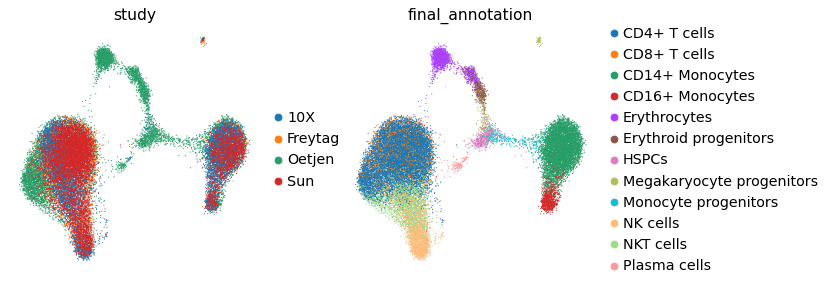

In [67]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [68]:
intr_cvae.save('model_w_hsic_ref_BINF_ablation')

In [69]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [70]:
kang_raw = sc.read('kang_count.h5ad')
sc.pp.normalize_per_cell(kang_raw)
sc.pp.log1p(kang_raw)

In [71]:
kang.raw = kang_raw

In [74]:
kang.obs['study'] = 'Kang'

In [72]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [75]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae,
                                               unfreeze_ext=True, # do not freeze the unannotated terms weights
                                               new_n_ext_decoder=6,
                                               new_n_expand_encoder=6)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 5
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 278
	Expanded Mean/Var Layer in/out: 300 6
Decoder Architecture:
	Cond layer in, ext, cond, out and :  278 6 5 1972
	with hard mask.


In [76]:
hsic = True
q_intr_cvae.use_hsic_ = hsic
q_intr_cvae.model.use_hsic = hsic
q_intr_cvae.hsic_one_vs_all_= hsic
q_intr_cvae.model.hsic_one_vs_all = hsic

In [77]:
# q_intr_cvae.train(
#     n_epochs=150, 
#     alpha_epoch_anneal=50, 
#     weight_decay=0., 
#     alpha_kl=0.2,
#     gamma_ext=0.70,
#     beta=4,
#     seed=2020,
#     use_early_stopping=False,
#     print_n_deactive=True,
#     use_hisc= hsic 
# )
q_intr_cvae.train(
    n_epochs=150, 
    alpha_epoch_anneal=50, 
    weight_decay=0., 
    alpha_kl=0.1,
    gamma_ext=0.7,
    beta=3,
    seed=2020,
    use_early_stopping=False,
    print_n_deactive=True,
    use_hisc= hsic,
    gamma_epoch_anneal= 50
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Active genes in extension terms: [1972 1972 1972 1972 1972 1972]
Sparcity share in extension terms: [0. 0. 0. 0. 0. 0.]
 |--------------------| 0.7%  - epoch_loss: 1038.27 - epoch_recon_loss: 1037.71 - epoch_kl_loss:   72.49 - epoch_hsic_loss:    0.19 - val_loss:  722.24 - val_recon_loss:  721.66 - val_kl_loss:   93.92 - val_hsic_loss:    0.19Active genes in extension terms: [1972 1972 1972 1972 1972 1972]
Sparcity share in extension terms: [0. 0. 0. 0. 0. 0.]
 |--------------------| 1.3%  - epoch_loss:  617.97 - epoch_recon_loss:  617.26 - epoch_kl_loss:  107.98 - epoch_hsic_loss:    0.17 - val_loss:  571.77 - val_recon_loss:  571.09 - val_kl_loss:  119.40 - val_hsic_loss:    0.15Active genes in extension terms: [1972 1971 1972 1972 1971 1972]
Sparcity share in extension terms: [0. 0. 0. 0. 0. 0.]
 |--------------------| 2.0%  - epoch_loss:  559.04 - epoch_recon_loss:  558.11 - epoch_kl_loss:  123.60 - epoch_hsic_loss:    0.15 - val_loss:  561.92 - val_recon_loss:  560.96 - val_kl_los

In [ ]:
q_intr_cvae.save('model_wo_hsic_ref_q_BINF_ablation')

In [151]:
ext_active = (q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 20

In [105]:
inactive_idx = ~q_intr_cvae.model.decoder.nonzero_terms()

In [106]:
inactive_idx[-len(ext_active):] = ~ext_active

In [107]:
terms = adata.uns['terms'].copy()

In [108]:
terms += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [ ]:
q_intr_cvae.save('model_w_hsic_qref_BINF_ablation')

In [110]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [111]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [92]:
sc.tl.umap(kang)

In [95]:
k_c = kang.copy()

In [96]:
# sc.pl.umap(k_c, color=["seurat_annotations"] +mhc)

In [97]:
sc.pp.normalize_total(k_c)
sc.pp.log1p(k_c)

In [152]:
ext_active

array([False, False,  True, False,  True,  True])

In [113]:
# select unannotated term to plot
idx = [terms.index(term) for term in ['unannotated_0','unannotated_1', 'unannotated_2','unannotated_3',

                                      'unannotated_4','unannotated_5']]
# # idx = [terms.index(term) for term in [ 'unannotated_2',
#                                       'unannotated_5']]

In [153]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]
kang.obs['unk3'] = latents[:, 0]
kang.obs['unk1'] = latents[:, 1]
kang.obs['Myeloid'] = latents[:, 2]
kang.obs['unk2'] = latents[:, 3]
kang.obs['IFN'] = latents[:, 4]
kang.obs['BDC'] = latents[:, 5]


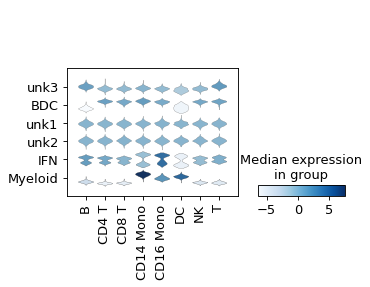

In [154]:
sc.pl.stacked_violin(kang, var_names=["unk3","BDC","unk1","unk2","IFN", "Myeloid"],
                     groupby="cell_type", swap_axes=True,
                     save="whsic_ablation")

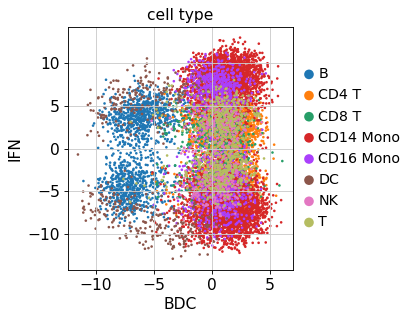

In [156]:
sc.pl.scatter(kang, x='BDC', y='IFN',
              color='cell_type',
              size=22, save="albation_whisc_ct")

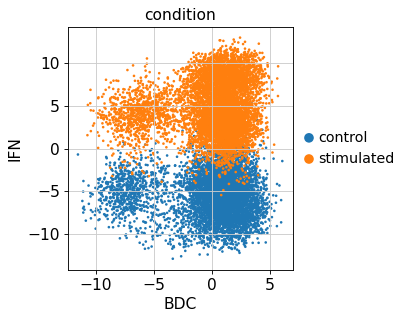

In [157]:
sc.pl.scatter(kang, x='BDC', y='IFN',
              color='condition',
              size=22, save="albation_whisc_cond")

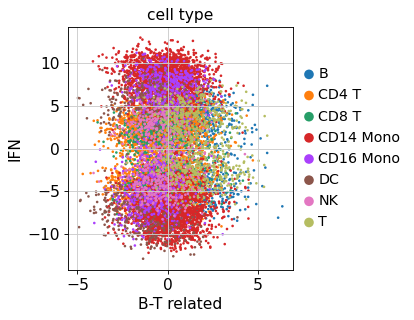

In [158]:
sc.pl.scatter(kang, x='B-T related', y='IFN',
              color='cell_type',
              size=22)

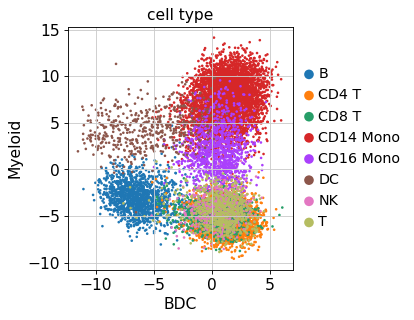

In [159]:
sc.pl.scatter(kang, x='BDC', y='Myeloid',
              color='cell_type',
              size=22)

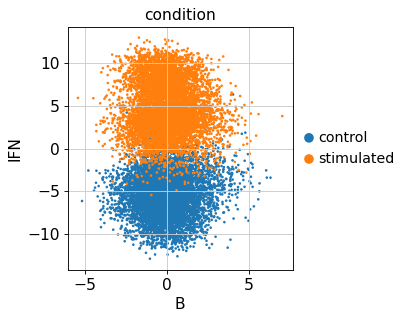

In [160]:
sc.pl.scatter(kang, x='B', y='IFN',
              color='condition',
              size=22)

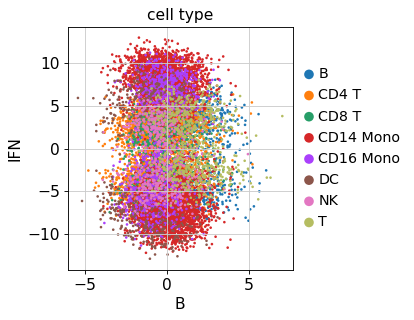

In [161]:
sc.pl.scatter(kang, x='B', y='IFN',
              color='cell_type',
              size=22)

In [162]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [163]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [164]:
latents.shape

(13576, 6)

In [165]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [166]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [167]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [168]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [169]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [170]:
categories

array(['B', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD4 T', 'CD4+ T cells', 'CD8 T',
       'CD8+ T cells', 'DC', 'Erythrocytes', 'Erythroid progenitors',
       'HSPCs', 'Megakaryocyte progenitors', 'Monocyte progenitors', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells', 'T'], dtype=object)

In [171]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [172]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [173]:
palette=['steelblue', 'skyblue', 'red']

... storing 'cell_type_joint' as categorical


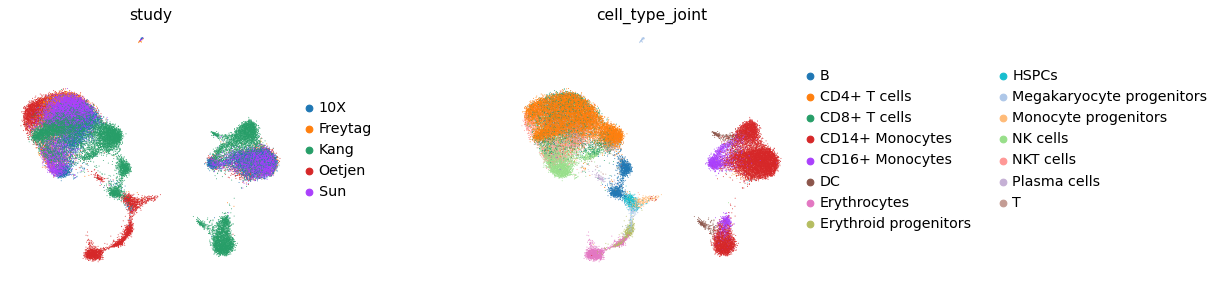

In [174]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

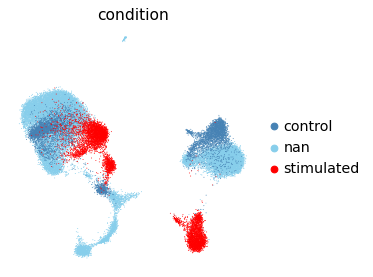

In [175]:
sc.pl.umap(kang_pbmc, color='condition',
           frameon=False, 
           wspace=0.6,
           palette=['steelblue', 'skyblue', 'red'])

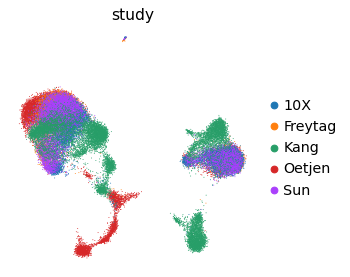

In [176]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

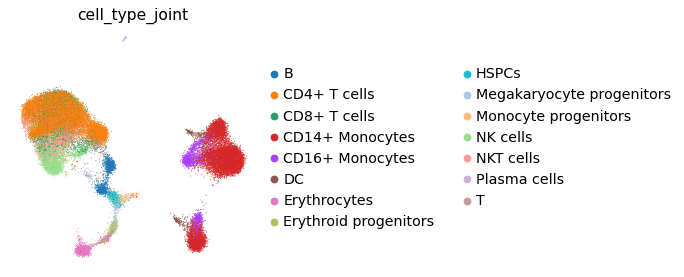

In [177]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

In [178]:
kang_pbmc.rename_categories("condition",['control (query)', 'control (reference)', 'INF-Beta'])

In [179]:

latents =  q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, idx]
kang_pbmc.obs['unk3'] = latents[:, 0]
kang_pbmc.obs['unk1'] = latents[:, 1]
kang_pbmc.obs['Myeloid'] = latents[:, 2]
kang_pbmc.obs['unk2'] = latents[:, 3]
kang_pbmc.obs['IFN'] = latents[:, 4]
kang_pbmc.obs['BDC'] = latents[:, 5]

In [186]:
ct_share = ['B',  'CD4+ T cells', 'CD8+ T cells', 'CD14+ Monocytes'
           , 'CD16+ Monocytes', 'NK cells', "DC", "T"]

In [187]:
kang_pbmc_ss = kang_pbmc[kang_pbmc.obs.cell_type_joint.isin(ct_share)]   

In [188]:
kang_pbmc

AnnData object with n_obs × n_vars = 42237 × 1972
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'B', 'IFN', 'unk3', 'unk', 'unk2', 'Myeloid', 'B-T related', 'B related', 'unk1', 'APC', 'S', 'BDC', 'batch_join', 'cell_type_joint'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    uns: 'neighbors', 'umap', 'study_colors', 'cell_type_joint_colors', 'condition_colors', 'cell_type_colors'
    obsm: 'X_cvae', 'X_umap'
    obsp: 'distances', 'connectivities'

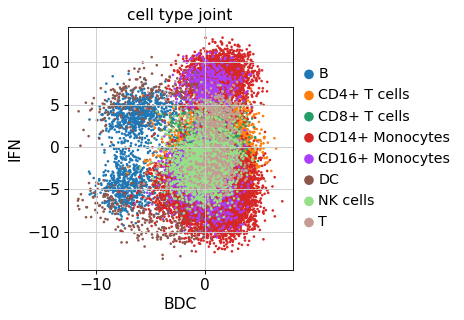

In [190]:
sc.pl.scatter(kang_pbmc_ss, x='BDC', y='IFN',
              color='cell_type_joint',
              size=22, save="albation_whisc_ct")

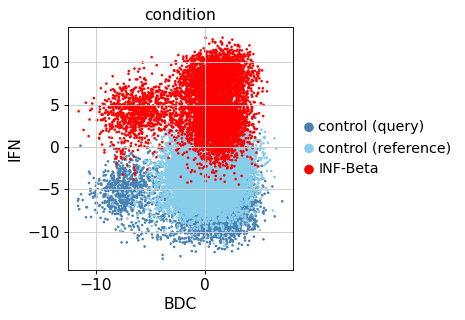

In [191]:
sc.pl.scatter(kang_pbmc_ss, x='BDC', y='IFN',
              color='condition',
              size=22, save="albation_whisc_cond")

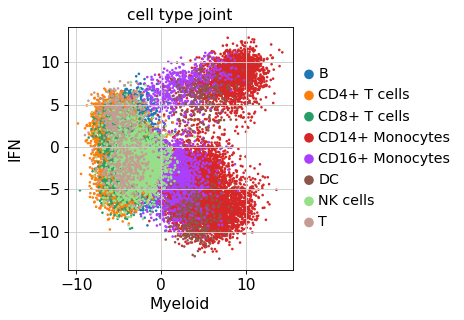

In [193]:
sc.pl.scatter(kang_pbmc_ss, x='Myeloid', y='IFN',
              color='cell_type_joint',
              size=22, save="BINF_all_t_inf__m_B_w_hsic_ablation.pdf")

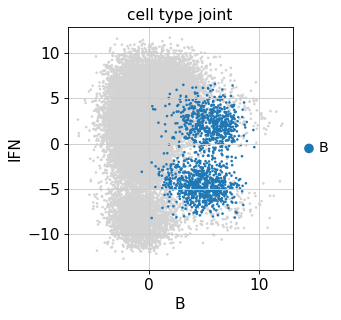

In [2767]:
sc.pl.scatter(kang_pbmc_ss, x='B', y='IFN', color='cell_type_joint', 
              size=22, groups=["B"], save="B_t_inf_B_w_hsic.pdf")

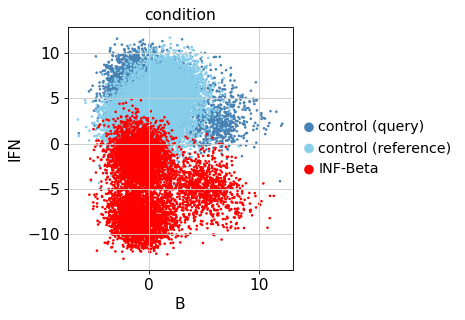

In [2768]:
sc.pl.scatter(kang_pbmc_ss, x='B', y='IFN', 
              color='condition', 
              size=22, save="B_t_inf_B_w_hsic_condition.pdf")

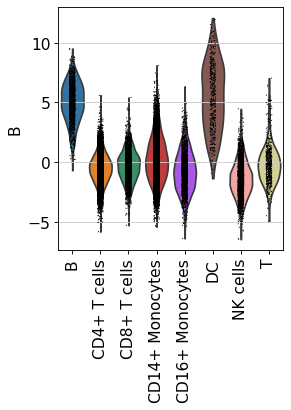

In [2769]:
sc.pl.violin(kang_pbmc_ss, keys="B",
             groupby="cell_type_joint",
             rotation=90, save="B_w_hsic")

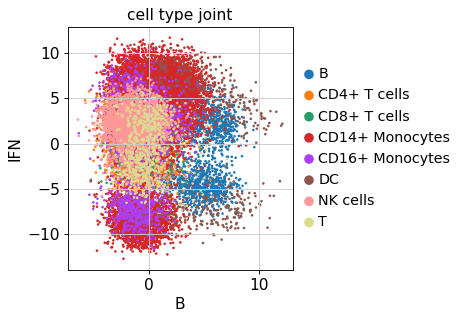

In [2770]:
sc.pl.scatter(kang_pbmc_ss, x='B', y='IFN',
              color='cell_type_joint',
              size=22, save="BINF_all_t_inf_B_w_hsic.pdf")

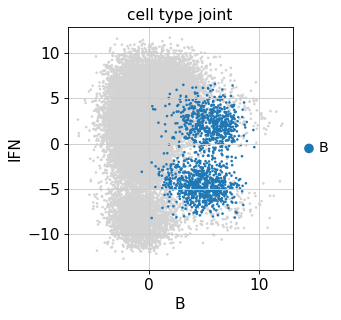

In [2771]:
sc.pl.scatter(kang_pbmc_ss, x='B', y='IFN',
              color='cell_type_joint',
              size=22, save="BINF_B_t_inf_B_w_hsic.pdf", groups="B")

In [2772]:
kang_pbmc.uns['terms'] = adata.uns['terms']

In [2773]:
# kang_pbmc.write('kang_pbmc_integrated_wo_hsic_infB.h5ad')

In [2774]:
IFN_GENES = ['ADAR','ARIH1', 'B2M','CAMK2D', 'CD44','CIITA', 'DDX58', 'EGR1', 'EIF2AK2', 'EIF4A3',
             'EIF4E', 'EIF4E3', 'EIF4G3', 'FCGR1A', 'FCGR1B', 'GBP1', 'GBP2', 'GBP4', 'GBP5', 'HERC5', 
             'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DRB1', 
             'HLA-DRB5', 'HLA-F', 'HLA-G', 'ICAM1', 'IFI27', 'IFI35', 'IFI6', 'IFIT1', 'IFIT2', 'IFIT3', 
             'IFITM1', 'IFITM2', 'IFITM3', 'IFNAR1', 'IFNAR2', 'IFNG', 'IFNGR1', 'IFNGR2', 'IRF1', 'IRF2', 
             'IRF3', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'JAK1', 'JAK2', 'KPNA1', 
             'KPNA2', 'MAPK3', 'MT2A', 'MX1', 'MX2', 'NCAM1', 'NUP205', 'NUP210', 'NUP214', 'NUP50', 
             'NUP88', 'NUPL2', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'PIAS1', 'PLCG1', 'PML', 'PPM1B', 'PRKCD', 
             'PTAFR', 'PTPN1', 'PTPN6', 'RANBP2', 'SOCS1', 'SOCS3', 'STAT1', 'STAT2', 'TRIM25', 'TYK2',
             'UBA7', 'USP18', 'XAF1']

In [2775]:
IFN_A_B_GENES = ['ISG15', 'IFI6', 'JAK1', 'GBP2', 'ADAR', 'STAT1', 'IRF2', 'IRF1', 'EGR1', 'IRF4', 
                 'HLA-F', 'HLA-G', 'HLA-A', 'HLA-C', 'HLA-B', 'IRF5', 'IFITM2', 'IFITM1', 'IFITM3', 
                 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1', 'PTPN6', 'STAT2', 'OAS1', 'OAS3', 'OAS2', 'OASL',
                 'IRF9', 'IFI27', 'ISG20', 'SOCS1', 'IRF8', 'XAF1', 'IFI35', 'SOCS3', 'PTPN1', 'TYK2', 
                 'IRF3', 'USP18', 'IFNAR2', 'IFNAR1', 'MX2', 'MX1']

In [2776]:
B_genes = ['PIK3CD',
 'CASP9',
 'BCL10',
 'THEM4',
 'SHC1',
 'AKT3',
 'RASGRP3',
 'SOS1',
 'PSME4',
 'REL',
 'PSMD14',
 'CREB1',
 'PSMD1',
 'CBLB',
 'NCK1',
 'RICTOR',
 'PIK3R1',
 'FBXW11',
 'PSMB9',
 'ITPR3',
 'CDKN1A',
 'NFKBIE',
 'FOXO3',
 'FYN',
 'CARD11',
 'SH3KBP1',
 'BTK',
 'IKBKG',
 'BLK',
 'IKBKB',
 'LYN',
 'SYK',
 'STIM1',
 'CBL',
 'PTEN',
 'BLNK',
 'PIK3AP1',
 'CHUK',
 'CDKN1B',
 'KRAS',
 'ITPR2',
 'NR4A1',
 'MDM2',
 'ORAI1',
 'FOXO1',
 'PSME2',
 'PSMA6',
 'NFKBIA',
 'PSMC6',
 'AKT1',
 'RASGRP1',
 'PSMA4',
 'TSC2',
 'PDPK1',
 'PRKCB',
 'CD19',
 'PLCG2',
 'CD79B',
 'PSMD12',
 'MALT1',
 'TRIB3',
 'PLCG1',
 'NFKBIB',
 'AKT2',
 'CD79A',
 'GSK3A']


mhc = ['CTSS',
 'CTSK',
 'KIFAP3',
 'KIF3C',
 'ACTR1B',
 'DYNC1I2',
 'SEC31A',
 'SEC24B',
 'SEC24D',
 'CTSO',
 'KIF2A',
 'SAR1B',
 'CD74',
 'DCTN4',
 'CANX',
'HLA-DRB5',
 'HLA-DRB1',
 'HLA-DQA1',
 'HLA-DQA2',
 'HLA-DOB',
 'HLA-DMB',
 'HLA-DMA',
 'HLA-DPA1',
 'HLA-DPB1',
 'AP1S2',
 'CTSB',
 'CTSD',
 'CTSF',
 'CTSC',
 'DYNC2H1',
 'SEC24C',
 'KIF11',
 'ACTR1A',
 'DYNLL1',
 'SEC23A',
 'DYNC1H1',
 'KIF23',
 'CTSH',
 'DCTN5',
 'KIF22',
 'DYNC1LI2',
 'AP1G1',
 'DYNLL2',
 'CLTC',
 'KIF3B',
 'CTSA',
 'DNM2',
 'AP1M1',
 'AP2S1',
 'AP2A1']

In [2778]:
unann_idx = 0

In [2779]:
import seaborn as sns

In [2780]:
x=q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].mean()

In [2781]:
x = q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].mean()

In [2782]:
x

tensor(0.001, device='cuda:0')

<AxesSubplot:ylabel='Count'>

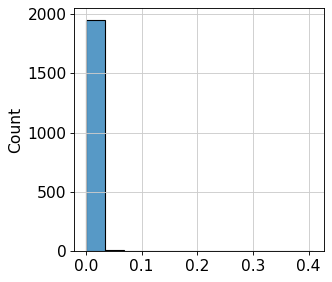

In [2783]:
sns.histplot(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu())

In [2784]:
unann_genes = adata.var_names[(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx]>x).cpu().numpy()].tolist()

In [2785]:
len(unann_genes)

94

In [2787]:
len(set(unann_genes).intersection(mhc))

10

In [2788]:
len(set(unann_genes).intersection(B_genes))

6

In [2789]:
len(set(unann_genes).intersection(IFN_A_B_GENES))

10

In [2790]:
srt = np.argsort(q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu().numpy())[::-1]

In [2812]:
unann_genes_top = adata.var_names[srt[:20]].tolist()

In [2816]:
unann_genes_top

['CD79A',
 'CD74',
 'BIRC3',
 'CCR7',
 'HERPUD1',
 'BLNK',
 'IRF8',
 'HLA-DMA',
 'REL',
 'TXN',
 'TCF4',
 'CD79B',
 'DUSP4',
 'PMAIP1',
 'UPP1',
 'HLA-DQA1',
 'HLA-DMB',
 'CYBA',
 'ZFP36L1',
 'CD19']

In [2813]:
len(set(unann_genes_top).intersection(B_genes))

5

In [2814]:
set(unann_genes_top).intersection(B_genes)

{'BLNK', 'CD19', 'CD79A', 'CD79B', 'REL'}

In [2815]:
set(unann_genes_top).intersection(mhc)

{'CD74', 'HLA-DMA', 'HLA-DMB', 'HLA-DQA1'}

In [2806]:
len(set(unann_genes_top).intersection(mhc))

4